In [1]:
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


## 💾 La Donnée

### De quoi avons-nous besoin ?
Pour mener cette enquête, nous devons constituer les "empreintes digitales" physico-chimiques des produits. Nous avons structuré notre dataset ainsi :

* 🎯 **La Cible (y) :** Le grade **Nutri-Score** (A, B, C, D, E).
* 🧪 **Les Indices (X) :** Les macronutriments bruts (sucre, sel, gras, fibres, protéines, etc.).
* 🏷️ **Le Contexte :** La catégorie du produit (on ne juge pas un fromage comme un soda).

### Source et Fiabilité : Le défi OpenFoodFacts
Nous avons choisi **OpenFoodFacts**, une base de données collaborative. Ce choix méthodologique est à double tranchant :

* ✅ **La Force (Réalisme) :** C'est le reflet du marché réel, pas un dataset aseptisé de laboratoire.
* ⚠️ **La Faiblesse (Bruit) :** C'est un chaos de données (erreurs de saisie, unités hétérogènes, doublons). La fiabilité brute est faible, rendant le **Data Cleaning** plus critique que la modélisation elle-même.

### Une démarche "Frugale" assumée
Nous avons délibérément choisi de ne pas travailler sur l'intégralité de la base (Big Data), mais sur un échantillon représentatif.

1.  **Sobriété Numérique :** Entraîner des modèles sur des millions de lignes pour un gain de précision marginal (0.01%) est un non-sens écologique.
2.  **Méthodologie > Volume :** Nous voulons démontrer qu'un échantillon propre et des *Smart Features* battent toujours un gros volume de données bruité. Cela nous permet de rester agiles et d'itérer rapidement.

---

## 🧹 Nettoyage : Imposer les lois de la physique

La première étape n'a pas été technique, mais **physique**. Pour valider nos ordres de grandeur, nous avons codé des règles immuables :

* ❌ **La règle des 100% :** Un produit ne peut pas contenir 150g de sucre pour 100g de matière. Nous avons supprimé ou "clampé" ces aberrations.
* 🔥 **La cohérence calorique :** Exclusion de tout produit dépassant **900 kcal/100g** (valeur de l'huile pure). Au-delà, c'est une erreur de saisie.

> **🚫 Traitement radical des valeurs manquantes (NaN)**
>
> Nous avons **refusé l'imputation par la moyenne**.
> *Remplacer une valeur manquante par la "moyenne du sucre" n'a aucun sens pour classer un produit réglementaire.*
>
> **Notre choix :** Si l'information manque, le produit est **écarté de l'apprentissage**. C'est une approche stricte, mais nécessaire pour garantir la pureté du modèle.

Enfin, pour la lisibilité, nous avons renommé les colonnes techniques de l'API (ex: `energy-kcal_100g`) en termes humains (`Energie`, `Sucre`), créant ainsi notre propre dictionnaire de variables.

In [2]:
from food_analyzer import *

### ⚙️ Stratégie d'aquisition des données

Pour garantir la fiabilité et la reproductibilité du dataset, nous avons implémenté une logique de collecte défensive :

- **Gestion intelligente de l'API (Pagination & Rate-Limiting) :** Nous récupérons les données par lots de 50 produits avec des temporisations (`sleep`) entre les appels.  
  *Pourquoi ?* Cette approche contourne les timeouts serveur, respecte les quotas de l'API OpenFoodFacts et évite le bannissement de notre IP.

- **Détection d'environnement (CI/CD vs Local) :** Le script détecte automatiquement s'il tourne sur GitHub Actions (`IS_CI`).  
  *Pourquoi ?* Cela permet de charger un dataset statique ou échantillonné lors des tests automatisés, rendant le pipeline d'intégration continue **rapide et déterministe**, sans dépendre de la disponibilité de l'API externe.

- **Tolérance aux pannes :** Intégration de mécanismes de "retry" en cas d'erreur HTTP.  
  *Pourquoi ?* Assure que la constitution du dataset ne s'arrête pas à la moindre micro-coupure réseau, garantissant une collecte complète des 500 produits visés par catégorie.

In [3]:
saved_dataset = True
df_final = downloader(saved_dataset) # Data cleaning encapsulé au sein même de l'étape de téléchargement des données
df_final

🌍 Lancement de la collecte
🤖 Utilisation du dataset 
--------------------------------------------------
🚀 DATASET FINAL : 2980 produits.
--------------------------------------------------
Répartition par Catégorie :
Category_Label
Céréales         482
Légumineuses     439
Biscuits         406
Légumes          400
Pizzas           393
Chocolats        336
Jus de Fruits    310
Fromages         214
Name: count, dtype: int64

Répartition par Nutriscore :
Nutriscore
A    669
B    336
C    829
D    601
E    545
Name: count, dtype: int64


,Nom,Marque,Nutriscore,Category_Label,Energie,Sucre,Gras,Saturés,Sel,Fibres,Protéines,Fruits et Légumes
0,"Muesli fibres - Son de blé, Figues, Pruneaux",Bjorg,A,Céréales,344.0,9.0,6.0,0.9,0.02,15.0,12.0,14.500000
1,Hrášek v mírně slaném nálevu,Bonduelle,A,Légumineuses,74.0,2.6,0.7,0.1,0.73,7.8,5.5,84.616494
2,Beanz Barbecue imp,Heinz,A,Légumineuses,81.0,5.7,0.2,0.1,0.50,3.9,4.9,91.482639
3,Haricots verts extra fins bio,Freshona,A,Légumineuses,23.0,0.5,0.4,0.2,0.55,0.0,1.5,85.534411
4,Lentilles vertes,"Carrefour BIO, Carrefour",A,Légumineuses,333.0,1.0,1.7,0.2,0.01,11.0,24.0,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2975,Noir Pérou éclats de menthe,Alter Eco,E,Chocolats,526.0,48.0,30.0,18.0,0.00,7.9,5.1,0.000000
2976,Noir aux Pépites de Café,Villars,E,Chocolats,520.0,45.0,34.0,20.0,0.03,6.7,4.6,0.000000
2977,NESTLE DESSERT Praliné,Nestlé,E,Chocolats,555.0,51.4,34.4,13.8,0.09,2.8,6.5,20.000000
2978,Toffee Cream Chocolate,Milka,E,Chocolats,539.0,52.0,33.0,18.0,0.41,1.0,4.6,0.045573


### 🥗 Sélection des Catégories

Nous avons délibérément ciblé 8 catégories hétérogènes (des *Légumes* aux *Pizzas* en passant par les *Chocolats*) pour maximiser la représentativité du dataset :

- **Couverture du spectre nutritionnel :** Cette sélection garantit une distribution variée des **Nutriscores (de A à E)** et des groupes **NOVA**, nous permettant de comparer des produits bruts (sains) à des produits ultra-transformés.
- **Variété des attributs :** En mixant boissons, plats préparés, produits secs et frais, nous capturons un large éventail de valeurs nutritionnelles (taux de sucre, gras, protéines), ce qui est indispensable pour éviter les biais d'analyse sur un seul type d'aliment.


### 🧪 Sélection des variables explicatives
Pour garantir la performance du modèle, nous avons retenu un vecteur de **8 variables quantitatives** et **1 variable catégorielle**, divisées en trois groupes stratégiques reflétant la logique officielle du Nutri-Score.

#### 1. Les composantes négatives (pénalisantes pour le nutri-score à priori)
Le Nutri-Score fonctionne par accumulation de "points négatifs" (N). Pour imiter ce comportement, nous avons sélectionné :

* **`nutriments.energy-kcal_100g`** : La densité énergétique est le premier facteur de pénalité.
    * Les variantes en kJ ont été écartées pour éviter la colinéarité parfaite (redondance d'information).
* **`nutriments.sugars_100g`** (Sucres totaux) :
    * L'algorithme actuel sanctionne les sucres totaux. Utiliser les sucres ajoutés (`added-sugars`) aurait induit le modèle en erreur sur les produits naturellement sucrés (ex: jus de fruits).
* **`nutriments.saturated-fat_100g`** (Acides gras saturés) :
    * Nous avons délibérément choisi les graisses saturées et non les graisses totales (`fat_100g`). Un produit peut être gras mais sain (ex: Huile de noix).
* **`nutriments.sodium_100g`**

#### 2. Les composantes Positives (valorisantes pour le nutri-score à priori)
Le score est atténué par des "points positifs" (P). Sans ces variables, le modèle ne peut pas expliquer pourquoi une pizza classée B est meilleure qu'une autre classée D.

* **`nutriments.fiber_100g`** (Fibres)
* **`nutriments.proteins_100g`** (Protéines)
* **`nutriments.fruits-vegetables-nuts-estimate-from-ingredients_100g`** :
    * Variable souvent latente (estimée). Sans elle, le modèle échoue systématiquement à prédire correctement les classes A et B des produits transformés mixtes (plats préparés).

#### 3. La variable de contextualisation

* **`Category_Label`** (Catégorie du produit) :
    * Le calcul du Nutri-Score n'est pas universel (grilles distinctes pour les "Matières grasses", "Boissons" et "Fromages").
    * *Impact ML :* Cette variable permet aux algorithmes non-linéaires (comme le Random Forest) de créer des embranchements conditionnels (ex: *"Si Fromage, alors tolérer plus de gras"*).



#### 🚫 Justification des variables rejetées
L'exclusion de variables est cruciale pour réduire le bruit et garantir la robustesse du modèle.

##### A. Élimination du Bruit (Micronutriments)
Nous avons exclu : `vitamin-c`, `calcium`, `iron`, `magnesium`, etc.
> Bien que vitaux, ces micronutriments n'entrent pas dans la formule du Nutri-Score. Les inclure créerait des corrélations fallacieuses (ex: le modèle associerait "Vitamine C" à "Bon score" uniquement parce que les fruits en contiennent, faussant l'analyse causale).

##### B. Standardisation des Unités (Biais d'échelle)
Nous avons exclu toutes les colonnes `_serving` (par portion) et `_unit`.
> Pour que le Machine Learning soit viable, les données doivent être comparables. Comparer 100g de biscuits à une portion de 30g introduirait un biais mathématique majeur. Nous travaillons exclusivement sur la base normalisée **Standard 100g**.

##### C. Prévention de la Fuite de Données (Data Leakage)
Nous avons exclu : `nutriscore_score` (le score numérique brut).
> C'est la réponse à l'équation (Target). Donner le score numérique au modèle pour prédire la classe (A-E) donnerait une précision artificielle de 100%, mais le modèle n'aurait rien appris sur la composition nutritionnelle réelle.


## 4. Exploration : Les surprises du dataset

Avant même de lancer le moindre algorithme, notre analyse exploratoire a révélé des comportements fascinants :
1.  **Le paradoxe du Sel :** On s'attend à ce que le sel soit très punitif. Or, les corrélations montrent qu'il pèse souvent moins lourd dans la balance que les graisses saturées.
2.  **Le "Loophole" des Fruits :** La variable `Fruits & Légumes` est un levier puissant. Nous avons découvert que certains produits très sucrés sauvent leur note uniquement grâce à un pourcentage élevé de fruits.
3.  **Les Outliers cachés :** En croisant les variables, nous avons trouvé des produits classés "A" avec 50g de sucre. Après investigation, il s'agissait souvent d'erreurs de catégorie (ex: de l'eau minérale mal renseignée). Ces anomalies ont été purgées.

---

In [4]:
distribution_nutriments_nutriscore(df_final)

🔍 Analyse détaillée par nutriment :


interactive(children=(Dropdown(description='nutriment_choisi', options=('Energie', 'Sucre', 'Gras', 'Saturés',…

In [5]:
impact_matrix_sugar(df_final).show()

In [6]:
corr_matrix(df_final).show()

In [7]:
distribution_nutriscore_par_famille_d_aliments(df_final).show()

In [8]:
nutriscore_par_marques(df_final).show()

In [9]:
sucre_gras(df_final)

👇 Change de catégorie pour mettre à jour instantanément :


interactive(children=(Dropdown(description='Filtre :', options=('Toutes', 'Biscuits', 'Chocolats', 'Céréales',…

## 5. Modélisation : Expliquer plutôt que prédire

### Notre approche : Classification supervisée
Nous cherchons à classer des produits dans des catégories discrètes (A, B, C, D, E). C'est un problème de classification pur.

### Le choix de l'arme : Random Forest
Pourquoi pas une régression Logistique ou un réseau de Neurones ?
Parce que le Nutri-Score fonctionne par **seuils** (ex: "Si sucre > 10g, alors -2 points"). Les algorithmes à base d'arbres de décision (*Random Forest, XGBoost*) imitent naturellement cette logique humaine de "si... alors...". De plus, ils offrent une interprétabilité directe via le `feature_importance`.


🟦 --- ÉTAPE 1 : BASELINE SIMPLE ---
👶 Mode BASIC : Utilisation des nutriments bruts.
✅ Dataset prêt : 16 variables en entrée.
📊 CV Score : 86.78% (+/- 1.02%)


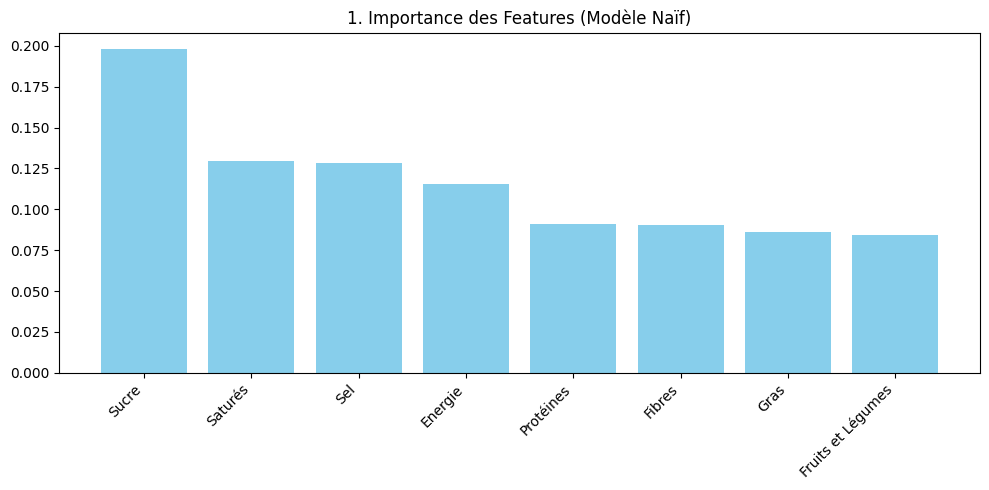

In [10]:
from food_analyzer.predictor import NutriModel
import matplotlib.pyplot as plt

# Initialisation
predictor = NutriModel(df_final)
scores_history = {} 

# =========================================================
# 1️⃣ TRAIN / TEST NORMAL (La Baseline)
# =========================================================
print("\n🟦 --- ÉTAPE 1 : BASELINE SIMPLE ---")
predictor.prepare_data(include_categorical=True)
predictor.train()
scores_history['1. Baseline'] = predictor.evaluate(method="cross_val")

# 📊 VUE 1 : Comment réfléchit le modèle "naïf" ?
predictor.plot_feature_importance(top_n=8, custom_title="1. Importance des Features (Modèle Naïf)")


🟨 --- ÉTAPE 2 : TUNING DU MODÈLE BASELINE ---
🔧 Optimisation en cours (Patience...)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
🎉 Meilleurs params : {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📊 CV Score : 86.34% (+/- 0.96%)


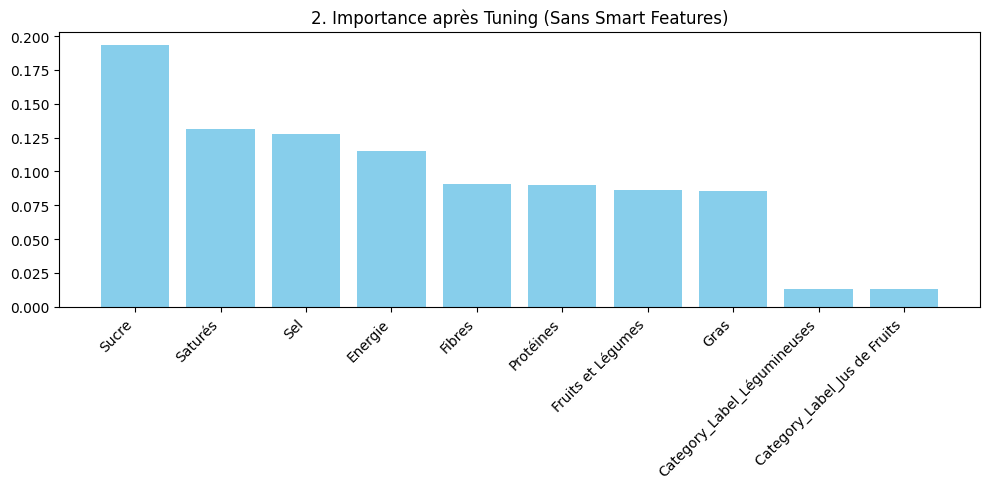

In [11]:
# =========================================================
# 2️⃣ HYPERPARAMÈTRES (Optimisation du modèle de base)
# =========================================================
print("\n🟨 --- ÉTAPE 2 : TUNING DU MODÈLE BASELINE ---")
predictor.optimize_hyperparameters()
scores_history['2. Baseline Tuned'] = predictor.evaluate(method="cross_val")

# 📊 VUE 2 : Est-ce que le tuning change la logique ?
predictor.plot_feature_importance(top_n=10, custom_title="2. Importance après Tuning (Sans Smart Features)")

### Le Feature Engineering
C'est ici que notre projet se distingue. Au lieu de jeter les données brutes au modèle, nous avons fait du **Reverse Engineering**.
Nous avons créé des "Smart Features" qui simulent la formule officielle :
* Nous avons calculé des ratios de densité (Sucre/Énergie).
* Nous avons créé une variable `Est_Score_Final` qui est la différence entre les points négatifs (gras, sucre) et positifs (fibres, protéines).

Pour dépasser le plafond de performance des modèles classiques (~84%), nous avons enrichi le jeu de données en intégrant des connaissances métier (Domain Knowledge). L'algorithme du Nutriscore n'est pas aléatoire : il repose sur une formule mathématique précise (Points_Négatifs−Points_Positifs). Au lieu de laisser le modèle "deviner" cette logique complexe uniquement à partir des valeurs brutes, nous avons créé des "Smart Features" qui simulent le calcul officiel :

Contextualisation (Ratios) : Les variables Ratio_Sucre_Energie et Ratio_Gras_Energie permettent au modèle de comprendre la densité nutritionnelle. 10g de sucre n'ont pas le même impact dans un biscuit hypercalorique que dans une boisson où ils représentent 100% de l'apport énergétique.

Simulation des Points (N et P) : Nous avons approximé les composantes du score officiel via Est_Points_Negatifs (somme pondérée de l'énergie, graisses saturées, sucre, sel) et Est_Points_Positifs (fibres, protéines, fruits). Cela projette les nutriments bruts sur une échelle linéaire comparable à celle du Nutriscore.

Score Final Estimé : La variable Est_Score_Final calcule la différence brute entre ces deux composantes. Elle agit comme un "indice fort" pour le modèle, lui permettant de se concentrer sur la classification des cas limites (les produits frontières entre C et D) plutôt que de devoir réapprendre l'arithmétique de base.

Impact : Cette injection de logique métier transforme le problème : le modèle ne cherche plus seulement des corrélations, il apprend à corriger et affiner une formule qu'on lui a partiellement mâchée.


🟩 --- ÉTAPE 3 : AJOUT DES SMART FEATURES ---
🧠 Injection des connaissances humaines (Smart Features)...
✅ Colonnes calculées ajoutées !
😎 Mode EXPERT : 5 smart features détectées.
✅ Dataset prêt : 21 variables en entrée.
📊 CV Score : 88.09% (+/- 1.05%)


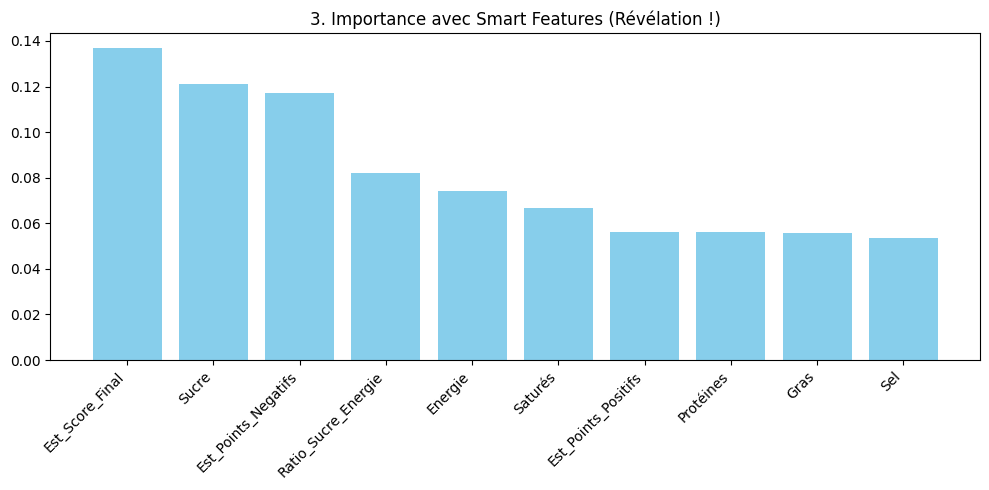

In [12]:
# =========================================================
# 3️⃣ FEATURE ENGINEERING (Le Game Changer)
# =========================================================
print("\n🟩 --- ÉTAPE 3 : AJOUT DES SMART FEATURES ---")
# 1. On injecte les calculs
predictor.add_smart_features()

# 2. On RE-PRÉPARE les données
predictor.prepare_data(include_categorical=True)

# 3. On RE-ENTRAÎNE
predictor.train() 
scores_history['3. Smart Features'] = predictor.evaluate(method="cross_val")

# 📊 VUE 3 : Le modèle a-t-il compris la formule ? (Regarde 'Est_Score_Final')
predictor.plot_feature_importance(top_n=10, custom_title="3. Importance avec Smart Features (Révélation !)")


🟧 --- ÉTAPE 4 : TUNING FINAL (SMART) ---
🔧 Optimisation en cours (Patience...)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
🎉 Meilleurs params : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📊 CV Score : 88.09% (+/- 1.05%)


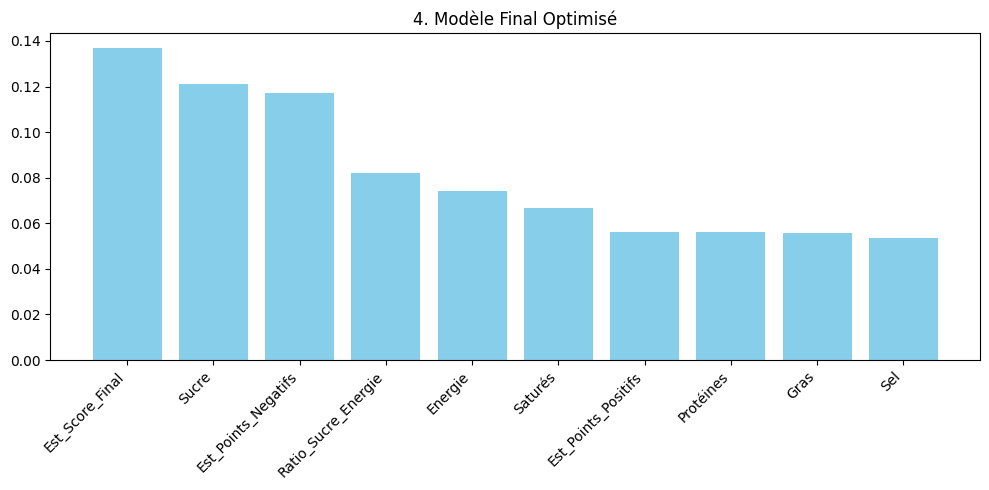

In [13]:
# =========================================================
# 4️⃣ HYPERPARAMÈTRES FINAL (Optimisation du modèle Smart)
# =========================================================
print("\n🟧 --- ÉTAPE 4 : TUNING FINAL (SMART) ---")
predictor.optimize_hyperparameters()
scores_history['4. Smart Tuned'] = predictor.evaluate(method="cross_val")

# 📊 VUE 4 : Le modèle ultime
predictor.plot_feature_importance(top_n=10, custom_title="4. Modèle Final Optimisé")

**Le résultat est sans appel :**
En nourrissant le modèle avec ces variables "métier", nous sommes passés d'une précision "plafond" à une meilleure compréhension de la logique avec un score bien supérieur.


             RÉSULTATS FINAUX             


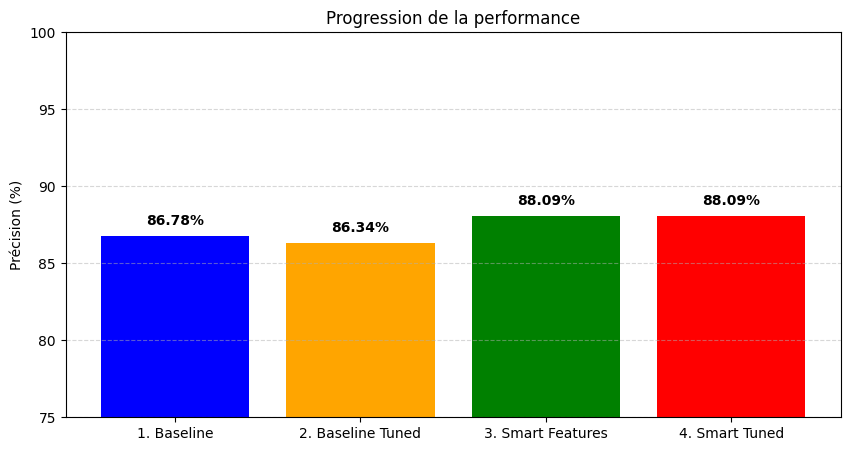

In [14]:
# =========================================================
# 🏆 BILAN FINAL
# =========================================================
print("\n" + "="*40)
print("             RÉSULTATS FINAUX             ")
print("="*40)

plt.figure(figsize=(10, 5))
bars = plt.bar(scores_history.keys(), [s*100 for s in scores_history.values()], 
               color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Précision (%)')
plt.title('Progression de la performance')
plt.ylim(75, 100) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
             f"{height:.2f}%", ha='center', va='bottom', fontweight='bold')
plt.show()